# Query of sessions

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
import os
import numpy as np
from one.api import ONE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from dateutil import parser
from datetime import datetime

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')
# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import download_subjectTables

In [3]:
base_query = (
    'session__projects__name__icontains,ibl_neuropixel_brainwide_01,'
    '~session__json__IS_MOCK,True,'
    'session__qc__lt,50,'
    'session__extended_qc__behavior,1,'
    '~json__qc,CRITICAL,'  # Should clarify these
    'json__extended_qc__alignment_count__gt,0,'  # No need for alignment resolved
)
qc_task = (
    '~session__extended_qc___task_stimOn_goCue_delays__lt,0.9,'
    '~session__extended_qc___task_response_feedback_delays__lt,0.9,'
    '~session__extended_qc___task_wheel_move_before_feedback__lt,0.9,'
    '~session__extended_qc___task_wheel_freeze_during_quiescence__lt,0.9,'
    '~session__extended_qc___task_error_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_correct_trial_event_sequence__lt,0.9,'
    '~session__extended_qc___task_reward_volumes__lt,0.9,'
    '~session__extended_qc___task_reward_volume_set__lt,0.9,'
    '~session__extended_qc___task_stimulus_move_before_goCue__lt,0.9,'
    '~session__extended_qc___task_audio_pre_trial__lt,0.9')

marked_pass = (
    'session__extended_qc___experimenter_task,PASS')  # What is this?

insertions = list(one.alyx.rest('insertions', 'list', django=base_query + qc_task))
insertions.extend(list(one.alyx.rest('insertions', 'list', django=base_query + marked_pass)))
print(len(insertions))

bwm_df = pd.DataFrame({
    'pid': np.array([i['id'] for i in insertions]),
    'eid': np.array([i['session'] for i in insertions]),
    'probe_name': np.array([i['name'] for i in insertions]),
    'session_number': np.array([i['session_info']['number'] for i in insertions]),
    'date': np.array([parser.parse(i['session_info']['start_time']).date() for i in insertions]),
    'subject': np.array([i['session_info']['subject'] for i in insertions]),
    'lab': np.array([i['session_info']['lab'] for i in insertions]),
}).sort_values(by=['lab', 'subject', 'date', 'eid'])
bwm_df.drop_duplicates(inplace=True)
bwm_df.reset_index(inplace=True, drop=True)


746


In [4]:
def extended_qc(one, eids):

    # Initialize df
    df = pd.DataFrame()

    for e, eid in enumerate(eids):
        try:
            extended_qc = one.get_details(eid, True)['extended_qc']
            transposed_df = pd.DataFrame.from_dict(extended_qc, orient='index').T
            transposed_df['eid'] = eid
            df = pd.concat([df, transposed_df])
        except:
            print(eid)
    return df


## Recording sessions

In [58]:
recording_sessions = bwm_df[['eid', 'date', 'subject']].drop_duplicates().copy()
rec_qc = extended_qc(one, recording_sessions['eid'].unique())

251ece37-7798-477c-8a06-2845d4aa270c


In [7]:
rec_qc_pass = rec_qc.loc[(rec_qc['task'].isin(['PASS', 'WARNING'])) &
                         (rec_qc['_lightningPoseLeft_lick_detection'].isin(['PASS'])) &
                         (rec_qc['_lightningPoseLeft_time_trace_length_match'].isin(['PASS'])) &   
                         (rec_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
                         (rec_qc['_lightningPoseLeft_trace_all_nan'].isin(['PASS'])) &
                         (rec_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                         (rec_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
                         (rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None
                         (rec_qc['_videoLeft_timestamps'].isin([True, 'PASS']))]
recording_sessions['qc'] = 0
recording_sessions.loc[recording_sessions['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
recording_sessions = recording_sessions.groupby('subject').apply(pd.DataFrame.sort_values, 'date', ascending=True).reset_index(drop=True)

In [9]:
recording_start_date = recording_sessions.groupby(['subject'])['date'].min().reset_index()
recording_start_date = recording_start_date.rename(columns={'date': 'recording_start_date'})
recording_sessions = recording_sessions.merge(recording_start_date, on=['subject'])
recording_sessions['order_recording']  = recording_sessions.groupby('subject').cumcount() + 1


(10.0, 0.0)

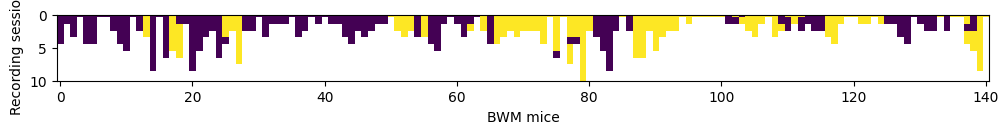

In [8]:
recording_grid = recording_sessions[['subject', 'qc', 'order_recording']].pivot(index="subject", columns="order_recording")

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(np.array(recording_grid).T,  interpolation='nearest')
plt.tight_layout()
plt.xlabel('BWM mice')
plt.ylabel('Recording sessions')
plt.ylim(10, 0)

## Extended sessions
- Get sessions after ready4ephysrig and before first recording

In [10]:

unique_mice = bwm_df['subject'].unique()
extended_sessions = pd.DataFrame(columns=['session', 'task_protocol', 'session_start_time', 'mouse_name'])

for mouse_name in unique_mice:
    recording_eids = bwm_df.loc[bwm_df['subject']==mouse_name, 'eid']
    
    subject_trials, subject_training = download_subjectTables(one, subject=mouse_name, trials=True, training=True,
                target_path=None, tag=None, overwrite=False, check_updates=True)
    dsets = [subject_trials[0], subject_training[0]]
    files = [one.cache_dir.joinpath(x) for x in dsets]
    trials, training = [pd.read_parquet(file) for file in files]
    training = training.reset_index()
    
    if 'ready4ephysrig' in np.array(training['training_status']):
        ready4ephysrig = list(training.loc[training['training_status']=='ready4ephysrig', 'date'])[0]
        ephys_rig_sessions = trials.loc[trials['session_start_time'] > 
                                        ready4ephysrig][['session', 'task_protocol', 'session_start_time']].drop_duplicates()
    else:
        ready4delay = list(training.loc[training['training_status']=='ready4delay', 'date'])[0]
        ephys_rig_sessions = trials.loc[trials['session_start_time'] > 
                                        ready4delay][['session', 'task_protocol', 'session_start_time']].drop_duplicates()
    first_recording_date = list(recording_sessions.loc[recording_sessions['subject']==mouse_name, 'recording_start_date'])[0]
    # Pre-recording sessions
    pre_recording_sessions = pd.DataFrame()
    pre_recording_sessions = ephys_rig_sessions.loc[(ephys_rig_sessions['task_protocol'].str.contains('biasedChoiceWorld')) |
                                                    (ephys_rig_sessions['task_protocol'].str.contains('ephysChoiceWorld'))].copy()
    pre_recording_sessions = pre_recording_sessions.loc[pre_recording_sessions['session_start_time']<pd.to_datetime(first_recording_date)].copy()
    pre_recording_sessions['mouse_name'] = mouse_name
    pre_recording_sessions = pre_recording_sessions[['session', 'task_protocol', 'session_start_time', 'mouse_name']]
    
    try:
        extended_sessions = pd.concat([extended_sessions, pre_recording_sessions], axis=0, ignore_index=True)
    except:
        print("Concat failed with error")
    
    # extended_sessions = pd.concat([extended_sessions, pd.DataFrame(pre_recording_sessions)], axis=0, ignore_index=True)

/tmp/ipykernel_8772/387445742.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_sessions = pd.concat([extended_sessions, pre_recording_sessions], axis=0, ignore_index=True)


Concat failed with error


In [11]:
extended_df = extended_sessions.copy()
rec_qc = extended_qc(one, extended_df['session'].unique())


bee3fb2c-824b-4883-9508-91c43978eed8
94535612-5064-40aa-aa05-8c08c2fa618a
29e74e5c-9557-41d6-966d-e9bac6e932fa
21d3bbdf-7cb1-4a86-bd7d-16d88c0e38b1
0cf783d4-770a-4953-92bb-5de03f3b389e
b84a61d2-8e1e-461a-bff1-16b44dc6cea3
aed565c2-8f5b-433f-bd30-ed45aedc33a0
6dda1b46-afe3-48ee-918b-c308ba7dd519
f55e0699-ebc3-447e-a4ff-d0ecf73f3018
ea436c57-944a-4cbd-af90-31e3c35e9116
9a926b27-6801-4fa4-a362-ebe916ee9009
9ecc2335-9a23-40c2-ae0b-c4087818bfd6
1114aa6e-a49b-4de7-9a9b-e6fc48ca5d46
b9b8fa2a-8949-4f79-ab6a-c90a3d068b55
55cbc068-dc37-4e5a-85dc-c7763b508049
75c51f31-aa98-40e8-b020-e55d7039b749
c0ba910e-3e8b-4596-b509-0e28a15c332b
1c5ae8dc-edd4-4ebd-9883-3d8fea79804f
8028df72-7f65-4609-9e6a-354f08648ae1
faff72fd-a15f-4b12-9f65-7746ae51be61
f4542bdd-9e51-4bff-9b56-915664a3a48a
e65de8fe-5b69-48fb-81d9-10abda28c3a6
468d2123-fbdc-4b8d-bcd2-c72bf345e408
1e6c2fed-8e6f-4ff6-b3ff-b982425ed8c6
acd8f6b6-ba57-4dcc-9afb-80713e23d354
bd5c63bd-296c-41b8-9cfb-a5be1f5fe24c
220dd4da-9277-4f15-978a-04c77475b93e
6

## Get last 3 which pass QC for processing with LP!


In [ ]:
rec_qc_pass = rec_qc.loc[(rec_qc['_videoLeft_dropped_frames'].apply(lambda x: x == [True, 0, 0] or x == 'PASS'))]  
# rec_qc_pass = rec_qc.loc[(rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS'))]  
extended_df['qc'] = 0
extended_df = extended_df.rename(columns={'session':'eid', 'mouse_name':'subject'})
extended_df.loc[extended_df['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
extended_df = extended_df.drop_duplicates()
extended_df['order_recording'] = -extended_df.groupby('subject')['session_start_time'].rank(method='first', ascending=False).astype(int)


In [28]:
# further check
eids = extended_df.loc[extended_df['qc']>0, 'eid']
count_df = pd.DataFrame(columns=['eid', 'frameData', 'frame_counter', 'GPIO', 'timestamps'], index=range(len(eids)))

for e, eid in enumerate(eids):
    count_df['eid'][e] = eid
    if 'raw_video_data/_iblrig_leftCamera.frameData.bin' in one.list_datasets(eid):
        count_df['frameData'][e] = 1
    else:
        count_df['frameData'][e] = 0
    if 'raw_video_data/_iblrig_leftCamera.frame_counter.bin' in one.list_datasets(eid):
        count_df['frame_counter'][e] = 1
    else:
        count_df['frame_counter'][e] = 0 
    if 'raw_video_data/_iblrig_leftCamera.GPIO.bin' in one.list_datasets(eid):
        count_df['GPIO'][e] = 1
    else:
        count_df['GPIO'][e] = 0 
    if 'raw_video_data/_iblrig_leftCamera.timestamps.ssv' in one.list_datasets(eid):
        count_df['timestamps'][e] = 1
    else:
        count_df['timestamps'][e] = 0 

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-03-03", "2022-10-31", "2023-04-04"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-03-03", "2022-10-31", "2023-04-04"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-03-03", "2022-10-31", "2023-04-04"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2025-03-03", "2022-10-31", "2023-04-04"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/util.py:543: ALFWarning: Multi

In [218]:
all_df = pd.concat([extended_df[['subject', 'eid', 'qc', 'order_recording']], recording_sessions[['subject', 'eid', 'qc', 'order_recording']]])
mice_with_rec = recording_sessions['subject'].unique()[list(recording_sessions.groupby('subject')['qc'].sum()>0)]
use_df = all_df.loc[all_df['subject'].isin(mice_with_rec)]
# use_df = all_df.copy()
unique_mice = use_df['subject'].unique()

sessions_for_LP = pd.DataFrame(columns=['mouse_name', 'session_1', 'session_2', 'session_3'], index = range(len(unique_mice)))

for m, mouse_name in enumerate(unique_mice):

    mouse_recordings = use_df.loc[use_df['subject']==mouse_name].sort_values(by='order_recording')
    mouse_extended = np.array(mouse_recordings.loc[(mouse_recordings['order_recording'] < 0) &
                                                   (mouse_recordings['qc']>0), 'eid'])
    mouse_good_recs = np.array(mouse_recordings.loc[(mouse_recordings['order_recording'] >= 0) &
                                                   (mouse_recordings['qc']>0), 'eid'])

    if len(mouse_extended) >0:
        eid_1 = [mouse_extended[-1]]
        all_df.loc[all_df['eid'].isin(eid_1), 'qc'] = 2
        sessions_for_LP['session_1'][m] = mouse_extended[-1]
    elif (len(mouse_extended) == 1) & (len(mouse_good_recs)<2):
        # If there is one extended session but no more than 1 good recording, there would be ony three sessions, so no need to extend
        sessions_for_LP['session_1'][m] = np.nan
    else:
        eid_1 = []
    if len(mouse_extended) >1:
        eid_2 = [mouse_extended[-2]]
        all_df.loc[all_df['eid'].isin(eid_2), 'qc'] = 2
        sessions_for_LP['session_2'][m] = mouse_extended[-2]
    else:
        eid_2 = []
    if len(mouse_extended) >2:
        eid_3 = [mouse_extended[-3]]
        all_df.loc[all_df['eid'].isin(eid_3), 'qc'] = 2
        sessions_for_LP['session_3'][m] = mouse_extended[-3]
    else:
        eid_3 = []
    
    sessions_for_LP['mouse_name'][m] = mouse_name
    
            

In [220]:
sessions_for_LP.to_parquet('sessions_LP_ines', compression='gzip') 

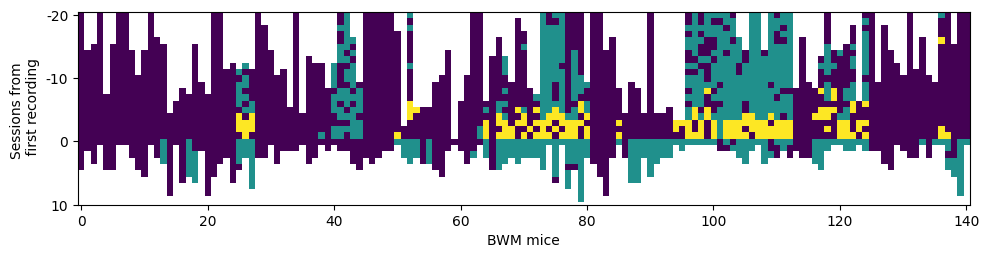

In [219]:
grid = all_df.drop(columns=['eid']).pivot(index=["subject"], columns="order_recording")

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(np.array(grid)[:, -33:-3].T,  interpolation='nearest')
plt.xlabel('BWM mice')
plt.ylabel('Sessions from \n first recording')
ax.set_yticks([0, 10, 20, 30], [-20, -10, 0, 10])

plt.tight_layout()

In [12]:
# rec_qc_pass = rec_qc.loc[(rec_qc['task'].isin(['PASS', 'WARNING'])) &
#                          (rec_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
#                          (rec_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
#                          (rec_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
#                          (rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &  # can make more conservative by removing or  x == None
#                          (rec_qc['_videoLeft_timestamps'].isin([True, 'PASS']))]
# extended_df['qc'] = 0
# extended_df = extended_df.rename(columns={'session':'eid', 'mouse_name':'subject'})
# extended_df.loc[extended_df['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
# extended_df = extended_df.drop_duplicates()
# extended_df['order_recording'] = -extended_df.groupby('subject')['session_start_time'].rank(method='first', ascending=False).astype(int)

In [13]:
# rec_qc_pass = rec_qc.loc[(rec_qc['task'].isin(['PASS', 'WARNING'])) &
#                          (rec_qc['_videoLeft_pin_state'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &
#                          (rec_qc['_videoLeft_framerate'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
#                          (rec_qc['_videoLeft_camera_times'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS')) &   
#                          (rec_qc['_videoLeft_dropped_frames'].apply(lambda x: x == [True, 0, 0] or x == 'PASS')) &  # can make more conservative by removing or  x == None
#                          (rec_qc['_videoLeft_timestamps'].isin([True, 'PASS']))]
# extended_df['qc'] = 0
# extended_df = extended_df.rename(columns={'session':'eid', 'mouse_name':'subject'})
# extended_df.loc[extended_df['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
# extended_df = extended_df.drop_duplicates()
# extended_df['order_recording'] = -extended_df.groupby('subject')['session_start_time'].rank(method='first', ascending=False).astype(int)

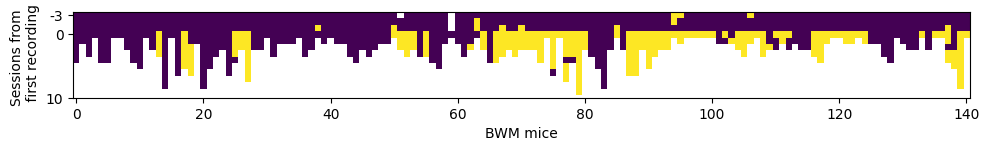

In [24]:
# all_df = pd.concat([extended_df[['subject', 'qc', 'order_recording']], recording_sessions[['subject', 'qc', 'order_recording']]])
# grid = all_df.pivot(index="subject", columns="order_recording")

# fig, ax = plt.subplots(figsize=(10, 3))
# ax.imshow(np.array(grid)[:, -16:-3].T,  interpolation='nearest')
# plt.xlabel('BWM mice')
# plt.ylabel('Sessions from \n first recording')
# ax.set_yticks([0, 3, 13], [-3, 0, 10])

# plt.tight_layout()


In [33]:
# rec_qc_pass = rec_qc.loc[(rec_qc['_videoLeft_dropped_frames'].apply(lambda x: x == [True, 0, 0] or x == 'PASS'))]  
# # rec_qc_pass = rec_qc.loc[(rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS'))]  
# extended_df['qc'] = 0
# extended_df = extended_df.rename(columns={'session':'eid', 'mouse_name':'subject'})
# extended_df.loc[extended_df['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
# extended_df = extended_df.drop_duplicates()
# extended_df['order_recording'] = -extended_df.groupby('subject')['session_start_time'].rank(method='first', ascending=False).astype(int)

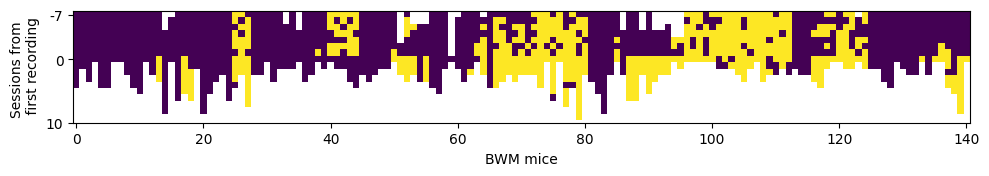

In [34]:
# all_df = pd.concat([extended_df[['subject', 'qc', 'order_recording']], recording_sessions[['subject', 'qc', 'order_recording']]])
# mice_with_rec = recording_sessions['subject'].unique()[list(recording_sessions.groupby('subject')['qc'].sum()>0)]
# use_df = all_df.loc[all_df['subject'].isin(mice_with_rec)]
# use_df = all_df.copy()

# grid = use_df.pivot(index="subject", columns="order_recording")

# fig, ax = plt.subplots(figsize=(10, 3))
# ax.imshow(np.array(grid)[:, -20:-3].T,  interpolation='nearest')
# plt.xlabel('BWM mice')
# plt.ylabel('Sessions from \n first recording')
# ax.set_yticks([0, 7, 17], [-7, 0, 10])

# plt.tight_layout()


In [36]:
# rec_qc_pass = rec_qc.loc[(rec_qc['_videoLeft_dropped_frames'].apply(lambda x: (isinstance(x, list) and True in x) or x == 'PASS'))]
# extended_df['qc'] = 0
# extended_df = extended_df.rename(columns={'session':'eid', 'mouse_name':'subject'})
# extended_df.loc[extended_df['eid'].isin(rec_qc_pass['eid'].unique()), 'qc'] = 1
# extended_df = extended_df.drop_duplicates()
# extended_df['order_recording'] = -extended_df.groupby('subject')['session_start_time'].rank(method='first', ascending=False).astype(int)

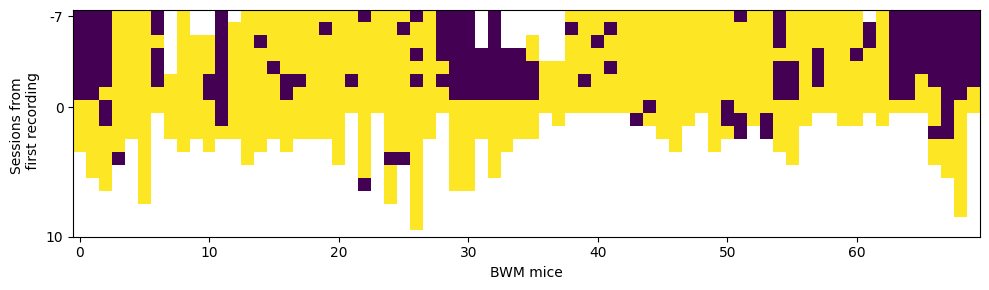

In [38]:
# all_df = pd.concat([extended_df[['subject', 'qc', 'order_recording']], recording_sessions[['subject', 'qc', 'order_recording']]])
# mice_with_rec = recording_sessions['subject'].unique()[list(recording_sessions.groupby('subject')['qc'].sum()>0)]
# use_df = all_df.loc[all_df['subject'].isin(mice_with_rec)]

# grid = use_df.pivot(index="subject", columns="order_recording")

# fig, ax = plt.subplots(figsize=(10, 3))
# ax.imshow(np.array(grid)[:, -20:-3].T,  interpolation='nearest')
# plt.xlabel('BWM mice')
# plt.ylabel('Sessions from \n first recording')
# ax.set_yticks([0, 7, 17], [-7, 0, 10])

# plt.tight_layout()